In [1]:
import numpy as np
import pandas as pd
import warnings
import tensorflow as tf 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
# from tqdm import tqdm_notebook
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from google.colab import drive
import sklearn
from sklearn import preprocessing
from matplotlib.pyplot import figure
sns.set_style("whitegrid")
sns.set_palette("colorblind")

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train = pd.read_csv('drive/MyDrive/project3/new_train_altered.csv')
val = pd.read_csv('drive/MyDrive/project3/new_val_altered.csv')
del train["Unnamed: 0"]
del val["Unnamed: 0"]

In [4]:
ALTERED = True

In [5]:
train = train[['sys_reg', 'hydro', 'micro', 'thermal', 'wind', 'flow',  'struct_imb',
       'y_lagged2', 'y_lagged3', 'mean_imbalance_12','imb_3d_bef',
       'mean_imbalance_24', 'mean_imbalance_48', 'altered_shift', 'y_lagged1', 'altered', 'y']]
val = val[['sys_reg', 'hydro', 'micro', 'thermal', 'wind', 'flow', 'struct_imb', 
       'y_lagged2', 'y_lagged3', 'mean_imbalance_12','imb_3d_bef',
       'mean_imbalance_24', 'mean_imbalance_48', 'altered_shift', 'y_lagged1', 'altered', 'y']]

**Normal task or altered task**

In [6]:
if ALTERED is False:
  del train['altered_shift']
  del val['altered_shift']
  del train['altered']
  del val['altered']
  del train['struct_imb']
  del val['struct_imb']
  del train['mean_imbalance_12']
  del val['mean_imbalance_12']
else:
  del train['y']
  del val['y']
  del train['y_lagged1']
  del val['y_lagged1']
  del train['y_lagged2']
  del val['y_lagged2']
  del train['y_lagged3']
  del val['y_lagged3']
  train.rename(columns = {'altered':'y'}, inplace = True)
  val.rename(columns = {'altered':'y'}, inplace = True)

In [7]:
train.columns

Index(['sys_reg', 'hydro', 'micro', 'thermal', 'wind', 'flow', 'struct_imb',
       'mean_imbalance_12', 'imb_3d_bef', 'mean_imbalance_24',
       'mean_imbalance_48', 'altered_shift', 'y'],
      dtype='object')

**NORMALIZATION**

In [8]:
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
y_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
y_train = y_scaler.fit_transform(train[['y']])
y_val = y_scaler.fit_transform(val[['y']])
train = scaler.fit_transform(train.values)
val = scaler.fit_transform(val.values)

**TRAINING - VALIDATION - TEST SET**

In [9]:
#I want to predict 8 future values
past_history = 120
to_predict = 50
# n_values = val.shape[0]-past_history #24 values in the future

future_values = val.shape[0]-to_predict
window = val.shape[0] - to_predict - past_history
test = val[future_values:, :]
window = val[window : future_values, :]
val = val[:future_values, :]
window, window_y = window[:, :-1], window[:, -1]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
val_X, val_y = val[:, :-1], val[:, -1]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
print(val_X.shape, val_y.shape)
print(window.shape)

(74739, 12) (74739,) (50, 12) (50,)
(9038, 12) (9038,)
(120, 12)


In [10]:
def plot_model_rmse_and_loss(history):
    
    # Evaluate train and validation accuracies and losses
    
    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Visualize epochs vs. train and validation accuracies and losses
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')
    
    plt.show()
    
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i + target_size -1])
        else:
            labels.append(target[i : i + target_size -1])

    return np.array(data), np.array(labels)

In [13]:
  X_train, y_train = multivariate_data(train_X, train_y,
                                     0, train_X.shape[0], 1, 
                                     0, step=1, single_step=True)
  X_train.shape

(74738, 1, 12)

In [16]:
import keras
from keras import backend as K
# from keras.engine.topology import Layer
import numpy as np
import tensorflow as tf
import keras
from keras import activations


class single_channel_interp(Layer):

  def __init__(self, ref_points, hours_look_ahead, **kwargs):
      self.ref_points = ref_points
      self.hours_look_ahead = hours_look_ahead  # in hours
      super(single_channel_interp, self).__init__(**kwargs)

  def build(self, input_shape):
      #input_shape [batch, features, time_stamp]
      self.time_stamp = input_shape[2]
      self.d_dim = input_shape[1] // 4
      self.activation = activations.get('sigmoid')
      self.kernel = self.add_weight(
          name='kernel',
          shape=(self.d_dim, ),
          initializer=keras.initializers.Constant(value=0.0),
          trainable=True)
      super(single_channel_interp, self).build(input_shape)

  def call(self, x, reconstruction=False):
      self.reconstruction = reconstruction
      x_t = x[:, :self.d_dim, :]
      d = x[:, 2*self.d_dim:3*self.d_dim, :]
      if reconstruction:
          output_dim = self.time_stamp
          m = x[:, 3*self.d_dim:, :]
          ref_t = K.tile(d[:, :, None, :], (1, 1, output_dim, 1))
      else:
          m = x[:, self.d_dim: 2*self.d_dim, :]
          ref_t = np.linspace(0, self.hours_look_ahead, self.ref_points)
          output_dim = self.ref_points
          ref_t.shape = (1, ref_t.shape[0])
      #x_t = x_t*m
      d = K.tile(d[:, :, :, None], (1, 1, 1, output_dim))
      mask = K.tile(m[:, :, :, None], (1, 1, 1, output_dim))
      x_t = K.tile(x_t[:, :, :, None], (1, 1, 1, output_dim))
      norm = (d - ref_t)*(d - ref_t)
      a = K.ones((self.d_dim, self.time_stamp, output_dim))
      pos_kernel = K.log(1 + K.exp(self.kernel))
      alpha = a*pos_kernel[:, np.newaxis, np.newaxis]
      w = K.logsumexp(-alpha*norm + K.log(mask), axis=2)
      w1 = K.tile(w[:, :, None, :], (1, 1, self.time_stamp, 1))
      w1 = K.exp(-alpha*norm + K.log(mask) - w1)
      y = K.sum(w1*x_t, axis=2)
      if reconstruction:
          rep1 = tf.concat([y, w], 1)
      else:
          w_t = K.logsumexp(-10.0*alpha*norm + K.log(mask),
                            axis=2)  # kappa = 10
          w_t = K.tile(w_t[:, :, None, :], (1, 1, self.time_stamp, 1))
          w_t = K.exp(-10.0*alpha*norm + K.log(mask) - w_t)
          y_trans = K.sum(w_t*x_t, axis=2)
          rep1 = tf.concat([y, w, y_trans], 1)
      return rep1

  def compute_output_shape(self, input_shape):
      if self.reconstruction:
          return (input_shape[0], 2*self.d_dim, self.time_stamp)
      return (input_shape[0], 3*self.d_dim, self.ref_points)

In [17]:
hours_look_ahead = 100
ref_points = 128
sci = single_channel_interp(ref_points, hours_look_ahead, weights=[np.array([-3.0])])
main_input = X_train
main_input = Input(shape=(4*num_features, timestamp), name='input')
interp = sci(main_input)
reconst = sci(main_input, reconstruction=True)

ValueError: ignored

**OPTUNA: A hyperparameter optimization framework**

In [ ]:
# def create_lstm_model(trial,X_train):
#   optimizer = "Adam"
#   model = tf.keras.Sequential()
#   lstm_unit1 = trial.suggest_int("lstm_unit1", 128, 512)
#   lstm_unit2 = trial.suggest_int("lstm_unit2", 128, 512)
#   lstm_unit3 = trial.suggest_int("lstm_unit3", 128, 512)
#   dropout = trial.suggest_float("dropout", 0.0, 0.4)
#   model.add(tf.keras.layers.LSTM(lstm_unit1,input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
#   model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
#   model.add(tf.keras.layers.LSTM(lstm_unit2,return_sequences=True))
#   model.add(tf.keras.layers.LeakyReLU(alpha = 0.5))
#   model.add(tf.keras.layers.Dropout(dropout))
#   model.add(tf.keras.layers.LSTM(lstm_unit3,return_sequences=False))
#   model.add(tf.keras.layers.Dropout(dropout))
#   model.add(tf.keras.layers.Dense(1))
#   model.compile(loss=loss, optimizer= optimizer, metrics = metric)
#   return model

In [ ]:
def create_lstm_model(X_train):
  optimizer = "Adam"
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.LSTM(128,input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
  model.add(tf.keras.layers.LSTM(128,return_sequences=True))
  model.add(tf.keras.layers.LeakyReLU(alpha = 0.5))
  model.add(tf.keras.layers.Dropout(0.1))
  model.add(tf.keras.layers.LSTM(64,return_sequences=False))
  model.add(tf.keras.layers.Dropout(0.1))
  model.add(tf.keras.layers.Dense(1))
  model.compile(loss=loss, optimizer= optimizer, metrics = metric)
  return model

In [ ]:
EPOCHS = 30# number of epocs per trial
# batch_size = 1024
# input_shape = X_train.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_lstm.h5', monitor=('val_loss'), save_best_only=True)
def objective(trial):  
  past_history = 120
  future_target = 0
  batch_size = 384
  buffer_size = 1000
  X_train, y_train = multivariate_data(train_X, train_y,
                                     0, train_X.shape[0], past_history, 
                                     future_target, step=1, single_step=True)
  X_val, y_val = multivariate_data(val_X, val_y,
                                 0, val_X.shape[0], past_history, 
                                 future_target, step=1, single_step=True)
  # Clear clutter from previous session graphs.
  keras.backend.clear_session()
  # Generate our trial model.
  model = create_lstm_model(X_train)

  initial_learning_rate = trial.suggest_float("initial_learning_rate", 0.0005, 0.005)

  decay = initial_learning_rate / EPOCHS
  def lr_time_based_decay(epoch, lr):
      return lr * 1 / (1 + decay * EPOCHS)

  scheduler1 = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, 400*((len(X_train)*0.8)/batch_size), 1e-6)
#learning rate scheduler
  def scheduler2(epoch, lr):
    if epoch < 10:
      return lr
    else:
      return lr * tf.math.exp(-0.1)
  scheduler = lr_time_based_decay
  lr = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)



  # Fit the model on the training data.
  model.fit(
      X_train,
      y_train,
      batch_size=batch_size,
      callbacks=[model_checkpoint, early_stopping, lr],
      epochs=EPOCHS,
      validation_data=(X_val,y_val),
      verbose=2,
  )

  # Evaluate the model accuracy on the validation set.
  score = model.evaluate(X_val, y_val, verbose=0)
  return score[1]

In [ ]:
!pip3 install optuna
import optuna

In [ ]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=40)
pruned_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_intermediate_values(study)

In [ ]:
import optuna
optuna.visualization.plot_param_importances(study)

**MODEL: STACKED LSTM**

In [ ]:
  # ENCODER/DECODER
  # model = Sequential()
  # model.add(LSTM(200,  input_shape=(X_train.shape[1], X_train.shape[2])))
  # model.add(RepeatVector(20))
  # model.add(LSTM(200,  return_sequences=True))
  # model.add(TimeDistributed(Dense(1)))
  # model.compile(loss=loss, optimizer= optimizer, metrics = metric)

In [ ]:
def create_lstm_model(X_train):
  optimizer = "Adam"
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.LSTM(128,input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
  model.add(tf.keras.layers.LSTM(128,return_sequences=True))
  model.add(tf.keras.layers.LeakyReLU(alpha = 0.5))
  model.add(tf.keras.layers.Dropout(0.1))
  model.add(tf.keras.layers.LSTM(64,return_sequences=False))
  model.add(tf.keras.layers.Dropout(0.1))
  model.add(tf.keras.layers.Dense(1))
  model.compile(loss=loss, optimizer= optimizer, metrics = metric)
  return model

In [ ]:
past_history = 120
future_target = 0
batch_size = 384
X_train, y_train = multivariate_data(train_X, train_y,
                                    0, train_X.shape[0], past_history, 
                                    future_target, step=1, single_step=True)
X_val, y_val = multivariate_data(val_X, val_y,
                                0, val_X.shape[0], past_history, 
                                future_target, step=1, single_step=True)
print("X_train shape is:" + str(X_train.shape))
print("y_train shape is:" + str(y_train.shape))
print("X_val shape is:" + str(X_val.shape))
print("y_val shape is:" + str(y_val.shape))

X_train shape is:(74619, 120, 12)
y_train shape is:(74619,)
X_val shape is:(8918, 120, 12)
y_val shape is:(8918,)


Epoch 1/200
195/195 [==============================] - 18s 51ms/step - loss: 0.0047 - root_mean_squared_error: 0.0683 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0576 - lr: 0.0010
Epoch 2/200
195/195 [==============================] - 9s 46ms/step - loss: 0.0014 - root_mean_squared_error: 0.0376 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0686 - lr: 9.9978e-04
Epoch 3/200
195/195 [==============================] - 9s 46ms/step - loss: 8.9623e-04 - root_mean_squared_error: 0.0299 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0380 - lr: 9.9956e-04
Epoch 4/200
195/195 [==============================] - 9s 47ms/step - loss: 7.1754e-04 - root_mean_squared_error: 0.0268 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0452 - lr: 9.9933e-04
Epoch 5/200
195/195 [==============================] - 9s 47ms/step - loss: 6.3510e-04 - root_mean_squared_error: 0.0252 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0392 - lr: 9.9911e-04
Epoch 6/200
195/195 [===============

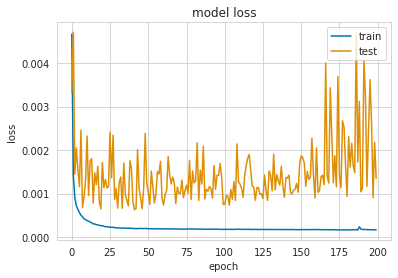

In [ ]:
EPOCHS = 200# number of epocs per trial
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
early_stopping = tf.keras.callbacks.EarlyStopping(patience=200)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_lstm.h5', monitor=('val_loss'), save_best_only=True)
buffer_size = 1000
# Clear clutter from previous session graphs.
keras.backend.clear_session()
# Generate our trial model.
model = create_lstm_model(X_train)

initial_learning_rate = 0.003
decay = initial_learning_rate / EPOCHS
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * EPOCHS)

scheduler = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, 400*((len(X_train)*0.8)/batch_size), 1e-6)
#learning rate scheduler
# def scheduler(epoch, lr):
#   if epoch < 10:
#     return lr
#   else:
#     return lr * tf.math.exp(-0.1)

lr = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

# Fit the model on the training data.
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    callbacks=[model_checkpoint, early_stopping, lr],
    epochs=EPOCHS,
    validation_data=(X_val,y_val),
    verbose=1,
)
model = tf.keras.models.load_model('multivariate_lstm.h5')
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig("drive/MyDrive/project3/plot/epochs.png")
plt.show()

**TEST PART**

In [ ]:
def prediction():
  predictions = []
  first_batch = window.reshape(1, window.shape[0], window.shape[1])
  current_batch = first_batch
  predictions = []
  for i in range(9):
    current_pred = model.predict(current_batch)
    if ( i is not 0):
      predictions.append(current_pred)
    current_batch_rmv_first = current_batch[:,1:,:]
    if(i < test_x.shape[0]):
      test_x[i][-1] = current_pred
    if(i + 1 < test_x.shape[0] and ALTERED is False):
      test_x[i+1][-6] = current_pred
    if(i + 2 < test_x.shape[0] and not ALTERED is False):
      test_x[i+2][-5] = current_pred
    if(i < test_x.shape[0]):
      current_batch = np.append(current_batch_rmv_first, [[test_x[i]]], axis = 1)
  return predictions

def error(predictions, window_y):
  y_window_inv = y_scaler.inverse_transform(window_y.reshape(-1, 1))
  pred_inv = y_scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
  rmse = np.sqrt(mean_squared_error(real_inv, pred_inv))
  print('Test RMSE: %.3f' % rmse)
  # print("r2: ",np.sqrt(sklearn.metrics.r2_score(real_inv, pred_inv)))
  print(f'MAE is : {sklearn.metrics.mean_absolute_error(real_inv, pred_inv)}')
  return y_window_inv, pred_inv


def plot(y_window_inv,pred_inv, real_inv, i):
  pred = np.concatenate((y_window_inv.reshape(y_window_inv.shape[0],1), pred_inv))
  real = np.concatenate((y_window_inv.reshape(y_window_inv.shape[0],1), real_inv))
  aa=[x for x in range(26)]
  figure(figsize=(8, 6), dpi=80)
  plt.plot(aa, pred[100:126], marker='.', label="prediction")
  plt.plot(aa, real[100:126], 'r', label="actual" )
  plt.ylabel('Imbalance', size=15)
  plt.xlabel('Time step', size=15)
  plt.legend(fontsize=15)
  if ALTERED is True:
    plt.savefig("drive/MyDrive/project3/plot2/altered/test"+str(i)+".png")
  else:
    plt.savefig("drive/MyDrive/project3/plot2/normal/test"+str(i)+".png")
  plt.show()

**TEST 1**

Test RMSE: 186.505
MAE is : 167.8755123369021


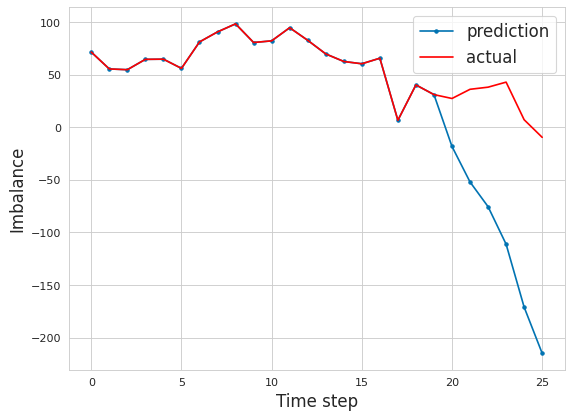

In [ ]:
window = window
window_y = window_y
test_x = test_X[0:8]
real_inv = y_scaler.inverse_transform(test_y[:8].reshape(-1, 1))
predictions = prediction()
y_window_inv, pred_inv = error(predictions, window_y)
plot(y_window_inv,pred_inv, real_inv, 1)

**TEST 2**

Test RMSE: 65.327
MAE is : 61.71776963473562


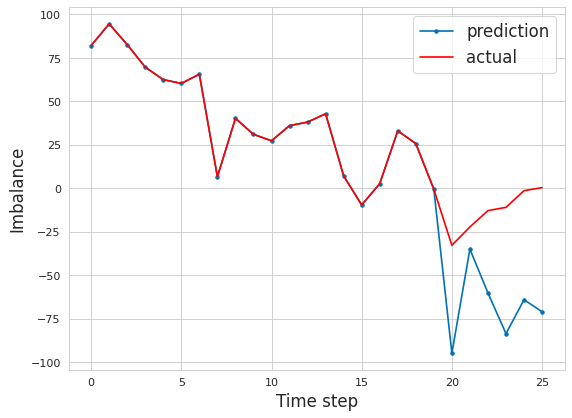

In [ ]:
window = np.concatenate((window[10:120], test_X[0:10]))
window_y = np.concatenate((window_y[10:120], test_y[0:10]))
test_x = test_X[10:18]
real_inv = y_scaler.inverse_transform(test_y[10:18].reshape(-1, 1))
predictions = prediction()
y_window_inv, pred_inv = error(predictions, window_y)
plot(y_window_inv,pred_inv, real_inv, 2)

**TEST 3**

Test RMSE: 47.841
MAE is : 37.55332343440162


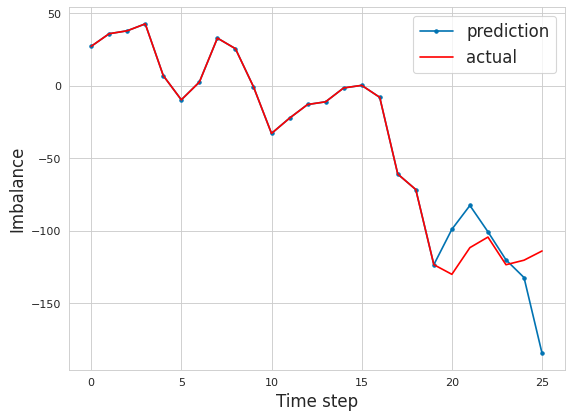

In [ ]:
window = np.concatenate((window[10:120], test_X[10:20]))
window_y = np.concatenate((window_y[10:120], test_y[10:20]))
test_x = test_X[20:28]
real_inv = y_scaler.inverse_transform(test_y[20:28].reshape(-1, 1))
predictions = prediction()
y_window_inv, pred_inv = error(predictions, window_y)
plot(y_window_inv,pred_inv, real_inv, 3)

**TEST 4**

Test RMSE: 223.334
MAE is : 213.59072376865336


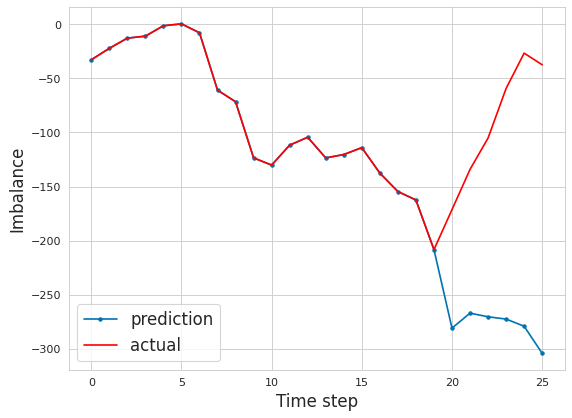

In [ ]:
window = np.concatenate((window[10:120], test_X[20:30]))
window_y = np.concatenate((window_y[10:120], test_y[20:30]))
test_x = test_X[30:38]
real_inv = y_scaler.inverse_transform(test_y[30:38].reshape(-1, 1))
predictions = prediction()
y_window_inv, pred_inv = error(predictions, window_y)
plot(y_window_inv,pred_inv, real_inv, 4)

**TEST 5**

Test RMSE: 54.608
MAE is : 51.265483089482174


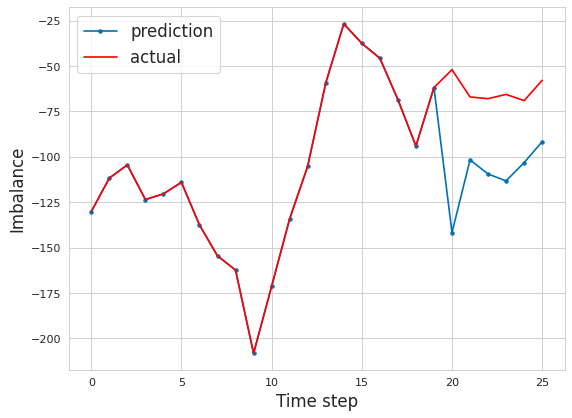

In [ ]:
window = np.concatenate((window[10:120], test_X[30:40]))
window_y = np.concatenate((window_y[10:120], test_y[30:40]))
test_x = test_X[40:48]
real_inv = y_scaler.inverse_transform(test_y[40:48].reshape(-1, 1))
predictions = prediction()
y_window_inv, pred_inv = error(predictions, window_y)
plot(y_window_inv,pred_inv, real_inv, 5)

In [ ]:
#standard model
# model = tf.keras.models.load_model('drive/MyDrive/project3/buono.h5') # removing balance12
# model = tf.keras.models.load_model('drive/MyDrive/project3/2904.h5') # removing balance12
# model = tf.keras.models.load_model('drive/MyDrive/project3/2804.h5') # removing balance12
# model = tf.keras.models.load_model('drive/MyDrive/project3/2804-2.h5') #best model removing balance12

# model = tf.keras.models.load_model('drive/MyDrive/project3/model0105.h5') #using altered data without struct_imb
# model = tf.keras.models.load_model('drive/MyDrive/project3/model0105_2.h5') #using altered data without struct_imb
# model = tf.keras.models.load_model('drive/MyDrive/project3/model0205.h5') #without imbalance12 and struct
# model = tf.keras.models.load_model('drive/MyDrive/project3/model0205-2.h5') #without imbalance12 and struct
model = tf.keras.models.load_model('drive/MyDrive/project3/0205-3.h5')#without imbalance12 and struct (very good)
# model = tf.keras.models.load_model('drive/MyDrive/project3/0305.h5')#without imbalance12 and struct (very good)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 120, 128)          72192     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 120, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 120, 128)          131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 120, 128)          0         
                                                                 
 dropout (Dropout)           (None, 120, 128)          0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [ ]:
#model with altered
# model = tf.keras.models.load_model('drive/MyDrive/project3/model_altered.h5') #without structural imbalance
model = tf.keras.models.load_model('drive/MyDrive/project3/altered2.h5') #with structural imbalance